## **Análise de Sentimentos usando Machine Learning**

* Criando modelos para análise de sentimentos de tweets
* Teste com Modelo usando tag de negações
* Teste com Modelo usando Bigrams

In [1]:
from nltk import word_tokenize
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

**Ler arquivo de dados e conta a quantidade de linhas**

In [3]:
dataset = pd.read_csv('Tweets_Mg.csv', encoding='utf-8')

**Exibe as 50 primeiras lihas de tweets**

In [4]:
dataset.Text.head(50)

0     ���⛪ @ Catedral de Santo Antônio - Governador ...
1     � @ Governador Valadares, Minas Gerais https:/...
2     �� @ Governador Valadares, Minas Gerais https:...
3                           ��� https://t.co/BnDsO34qK0
4     ��� PSOL vai questionar aumento de vereadores ...
5     " bom é bandido morto"\nDeputado Cabo Júlio é ...
6     "..E 25% dos mineiros dizem não torcer para ti...
7     "A gigantesca barba do mal" em destaque no cad...
8     "BB e governo de Minas travam disputa sobre de...
9     "com vcs bh fica pequena!" Belo Horizonte (pro...
10    "Daí a gente visita governador valadares"\n"Qu...
11    "É bonita e é bonita..." \n#latergram #ibituru...
12    "erro desconhecido" é mato! Aliás, é da secret...
13    "La La Land: Cantando Estações" arrasa no Glob...
14    "La La Land: Cantando Estações" arrasa no Glob...
15    "Los abusos, aun en el estado más sólido, son ...
16    "Mesmo sem muito dinheiro no caixa o governo d...
17    "Modelo de segurança será o nosso legado",

**Conta a quantidade de linhas de tweets neutros, positivos e negativos**

In [5]:
dataset[dataset.Classificacao=='Neutro'].count()

Unnamed: 0                   2453
Created At                   2453
Text                         2453
Geo Coordinates.latitude      102
Geo Coordinates.longitude     102
User Location                1712
Username                     2453
User Screen Name             2453
Retweet Count                2453
Classificacao                2453
Observação                      0
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

In [6]:
dataset[dataset.Classificacao=='Positivo'].count()

Unnamed: 0                   3300
Created At                   3300
Text                         3300
Geo Coordinates.latitude        1
Geo Coordinates.longitude       1
User Location                2118
Username                     3300
User Screen Name             3300
Retweet Count                3300
Classificacao                3300
Observação                      1
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

In [7]:
dataset[dataset.Classificacao=='Negativo'].count()

Unnamed: 0                   2446
Created At                   2446
Text                         2446
Geo Coordinates.latitude        1
Geo Coordinates.longitude       1
User Location                1659
Username                     2446
User Screen Name             2446
Retweet Count                2446
Classificacao                2446
Observação                      0
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

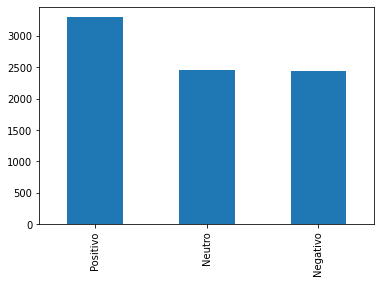

In [8]:
%matplotlib inline
dataset.Classificacao.value_counts().plot(kind='bar')

In [9]:
dataset.count()

Unnamed: 0                   8199
Created At                   8199
Text                         8199
Geo Coordinates.latitude      104
Geo Coordinates.longitude     104
User Location                5489
Username                     8199
User Screen Name             8199
Retweet Count                8199
Classificacao                8199
Observação                      1
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

## **Pre-Processamento dos Dados**

* Remove linhas duplicadas na base de dados
    - Problema na coleta dos dados.
* Remove Stopwords
* Faz Stemming nos dados
* Remove caracteres indesejados como links, pontuação etc.

In [11]:
dataset.drop_duplicates(['Text'], inplace=True)

In [12]:
dataset.Text.count()

5765

## **Separando tweets e suas Classes**

In [13]:
tweets = dataset['Text']
classes = dataset['Classificacao']

**Instala bibliotecas e baixa a base de dados**

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

**Funções de Pre-processamento de dados**

In [15]:
def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [16]:
def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [20]:
def Limpeza_dados(instancia):
    # remove links, pontos, virgulas,ponto e virgulas dos tweets
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

**Entenda como funciona cada função**

In [17]:
RemoveStopWords('Eu não gosto do partido, e também não votaria novamente nesse governante!')

'Eu gosto partido, votaria novamente nesse governante!'

In [18]:
Stemming('Eu não gosto do partido, e também não votaria novamente nesse governante!')

'eu não gost do partido, e também não vot nov ness governante!'

In [21]:
Limpeza_dados('Assita aqui o video do Governador falando sobre a CEMIG https://www.uol.com.br :) ;)')

'assita aqui o video do governador falando sobre a cemig   '

**Aplica as 3 funções de Pre-processamento nos dados**

In [23]:
def Preprocessing(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

# Aplica a função em todos os dados:
tweets = [Preprocessing(i) for i in tweets]

In [24]:
Preprocessing('Eu não gosto do partido, e também não votaria novamente nesse governante. Assita o video aqui https:// :)')

'gost partido, vot nov ness govern assit vide aqu'

**Visualize os dados e veja como ficou após o pré-processamento**

In [25]:
tweets[:50]

['���⛪ @ catedr sant antôni govern valadares/mg',
 '� @ govern valadares, min geral',
 '�� @ govern valadares, min geral',
 '���',
 '��� psol vai quest aument vere prefeit bh justiç poli est min',
 '" bom band morto" deput cab júli conden fic ineleg 10 ano poli est min',
 '"e 25% min diz torc tim nenhum,mesm dentr est atléticomg cruz pq?"',
 '"a gigantesc barb mal" destaqu cadern cult est min',
 '"bb govern min tr disput sobr depósit judiciais"',
 '"com vc bh fic pequena!" bel horizont (pron [bɛloɾiˈzõntʃi][10] capit est mg, áre aproximad 331 km²',
 '"daí gent visit govern valadares" "qu lug eh mãe?" "mg, gent um parent la" man ond q parent',
 '"é bonit bonita" #latergr #ibiturun #hom @ govern valadares, min geral',
 '"err desconhecido" mato! aliás, secret estad fazend tá assim mg precis dinh não, governador?',
 '"la la land cant estações" arras glob our est min',
 '"la la land cant estações" arras glob our est min',
 '"lo abusos, aun en el est má sólido, son min sord tard tempr estall

## **Criando o modelo**

**Instancia o objeto que faz a vetorização dos dados de texto**

In [27]:
vectorizer = CountVectorizer(analyzer="word")

**Aplica o vetorizador nos dados de texto**

In [28]:
freq_tweets = vectorizer.fit_transform(tweets)
type(freq_tweets)

scipy.sparse.csr.csr_matrix

In [29]:
modelo = MultinomialNB()
modelo.fit(freq_tweets,classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Formato (Linhas, Colunas) da matriz**

In [30]:
freq_tweets.shape

(5765, 5903)

**Matriz**

In [31]:
freq_tweets.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**Testando o modelo com algumas instâncias simples**

In [32]:
# defina instâncias de teste dentro de uma lista
testes = ['Esse governo está no início, vamos ver o que vai dar',
          'Estou muito feliz com o governo de Minas esse ano',
          'O estado de Minas Gerais decretou calamidade financeira!!!',
          'A segurança desse país está deixando a desejar',
          'O governador de Minas é mais uma vez do PT']

**Aplica a função de Pré-processamento nos dados**

In [37]:
testes = [Preprocessing(i) for i in testes]

In [38]:
# Transforma os dados de teste em vetores de palavras.
freq_testes = vectorizer.transform(testes)

In [39]:
# Fazendo a classificação com o modelo treinado.
for t, c in zip (testes,modelo.predict(freq_testes)):
    print (t +", "+ c)

govern início, vam ver vai dar, Neutro
feliz govern min ano, Neutro
est min geral decret calam financeira!!!, Negativo
seguranç dess país deix desej, Neutro
govern min vez pt, Negativo


In [40]:
# Probabilidades de cada classe
print (modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

['Negativo' 'Neutro' 'Positivo']


array([[0.12, 0.88, 0.  ],
       [0.02, 0.96, 0.02],
       [1.  , 0.  , 0.  ],
       [0.01, 0.98, 0.01],
       [0.67, 0.32, 0.  ]])

## **Função de Tags de Negações**

* Acrescenta uma tag _NEG encontrada após um 'não'.
* Objetivo é dar mais peso para o modelo identificar uma inversão de sentimento da frase.
* Exemplos: 
    - Eu gosto de cachorros, positivo.
    - Eu **não** gosto de cachorros, negativo.

In [42]:
def marque_negacao(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

**Exemplos de utilização da tag de negações**

In [43]:
marque_negacao('Eu gosto do partido, votaria novamente nesse governante!')

'eu gosto do partido, votaria novamente nesse governante!'

In [44]:
marque_negacao('Eu Não gosto do partido, e também não votaria novamente nesse governante!')

'eu não gosto_NEG do_NEG partido,_NEG e_NEG também_NEG não_NEG votaria_NEG novamente_NEG nesse_NEG governante!_NEG'

## **Criando modelos com Pipelines**

* Pipelines são interessantes para reduzir código e automatizar fluxos

In [46]:
from sklearn.pipeline import Pipeline

In [47]:
pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

* Pipeline que atribui tag de negacoes nas palavras

In [48]:
pipeline_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', MultinomialNB())
])

In [49]:
pipeline_simples.fit(tweets,classes)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [50]:
pipeline_simples.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

* Gera o modelo de negações

In [51]:
pipeline_negacoes.fit(tweets,classes)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x7f17ddd06c20>,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

* Etapas do pipeline

In [52]:
pipeline_negacoes.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=<function <lambda> at 0x7f17ddd06c20>,
                  vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

## **Validando os Modelos com Validação Cruzada**

* Fazendo o cross validation do modelo

In [53]:
resultados = cross_val_predict(pipeline_simples, tweets, classes, cv=10)

* Medindo a acurácia média do modelo

In [54]:
metrics.accuracy_score(classes,resultados)

0.8631396357328708

* Medidas de validação do modelo

In [55]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.96      0.86      0.91      2840
    Negativo       0.77      0.90      0.83       951
      Neutro       0.80      0.85      0.82      1974

    accuracy                           0.86      5765
   macro avg       0.84      0.87      0.85      5765
weighted avg       0.87      0.86      0.87      5765



* Matriz de confusão

In [56]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       852      91         8   951
Neutro         196    1674       104  1974
Positivo        64     326      2450  2840
All           1112    2091      2562  5765


## **Modelo com a Tag de Negações**

In [57]:
resultados = cross_val_predict(pipeline_negacoes, tweets, classes, cv=10)

* Medindo a acurácia média do modelo

In [58]:
metrics.accuracy_score(classes,resultados)

0.6993928881179532

In [59]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.72      0.83      0.77      2840
    Negativo       0.66      0.53      0.59       951
      Neutro       0.69      0.59      0.64      1974

    accuracy                           0.70      5765
   macro avg       0.69      0.65      0.66      5765
weighted avg       0.70      0.70      0.69      5765



* Matriz de confusão

In [60]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       502     170       279   951
Neutro         149    1169       656  1974
Positivo       113     366      2361  2840
All            764    1705      3296  5765


      O modelo que atribuiu tags de negações nao se saiu bem.

## **Avaliando modelo com Bigrams**

Dupla de palavras, em conjunto

In [61]:
'eu gosto', 'gosto do' , 'do brasil'

('eu gosto', 'gosto do', 'do brasil')

In [62]:
vectorizer = CountVectorizer(ngram_range=(1,2))
freq_tweets = vectorizer.fit_transform(tweets)
modelo = MultinomialNB()
modelo.fit(freq_tweets,classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [63]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)

In [64]:
metrics.accuracy_score(classes,resultados)

0.8659150043365135

In [65]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.96      0.87      0.92      2840
    Negativo       0.70      0.93      0.80       951
      Neutro       0.84      0.82      0.83      1974

    accuracy                           0.87      5765
   macro avg       0.84      0.88      0.85      5765
weighted avg       0.88      0.87      0.87      5765



In [66]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       889      59         3   951
Neutro         264    1621        89  1974
Positivo       118     240      2482  2840
All           1271    1920      2574  5765


## **Considerações Finais**

* Considere aumentar a quantidade de dados de treino.

* Pela sua simplicidade o Naive Bayes pode ser usado perfeitamente como um algoritmo de Baseline.

* Considere alterar os parâmetros do algoritmo.